In [1]:
# imports, run code in KPI_venv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
#import ibis
from datetime import datetime
import ast
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
import os
import random
import re
import string
#import nltk
import numpy as np
import pandas as pd
#from gensim.models import Word2Vec
#from nltk import word_tokenize
#from nltk.corpus import stopwords
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
#import shap

In [2]:
import numpy as np
import pandas as pd
df = pd.read_csv('../data/Training_Data_2305.csv')
df = df.sample(n=10, replace=False,random_state=4)
pd.set_option('display.max_colwidth', None)

In [3]:
df.head(10)

,COMMENTS_LONG,tokens,clean,Without PII,Topic,Category,ASSET_NUM,Words,Second Topic,Second Category,Vlookup
1858,date: * \nreason for call: xfered from tech - calling back as desperate for broadband to go line \naction taken: fttp order completed 19.1.24 ( from another cp) : vol013-828046934669 / broadbandeu54912428 * orange light on hub since 19.1.24 but ont has all green lights * hview cannot access hub * new in ws does not recognise * checked order in ws and this is still open (hud does not show any order info for broadbandeu54912428 or ) * checked interactions and can see notes that customers broadband order us stuck and has an open exception which has been chased and nrd / activation is expected for * cust works from home and cannot * wife works from home and cannot - already used all her mobile data * son studying for a levels and cannot as ee dongle pre sent is too slow * apologised for poor experience . i have added gb mobile data to wife emmas ee mobile (info data pass gb move house data boost [ yhaddac20 ] was purchased successfully for msisdn ) (cust and son have unlimited) * no ee hot spots * complaint logged and callback booked for * \nnext action due : call ish .. mobile .. has broadband connected ? can we see the broadband in or ws broadbandeu54912428 .. customer knows auto comp will be payable from 19.1.24 *,"['date', 'reason', 'for', 'call', 'xfered', 'from', 'tech', 'calling', 'back', 'as', 'desperate', 'for', 'broadband', 'to', 'go', 'line', 'action', 'taken', 'fttp', 'order', 'completed', 'from', 'another', 'cp', 'orange', 'light', 'on', 'hub', 'since', 'but', 'ont', 'has', 'all', 'green', 'lights', 'hview', 'can', 'not', 'access', 'hub', 'new', 'in', 'ws', 'does', 'not', 'recognise', 'checked', 'order', 'in', 'ws', 'and', 'this', 'is', 'still', 'open', 'hud', 'does', 'not', 'show', 'any', 'order', 'info', 'for', 'or', 'checked', 'interactions', 'and', 'can', 'see', 'notes', 'that', 'customers', 'broadband', 'order', 'us', 'stuck', 'and', 'has', 'an', 'open', 'exception', 'which', 'has', 'been', 'chased', 'and', 'nrd', 'activation', 'is', 'expected', 'for', 'cust', 'works', 'from', 'home', 'and', 'can', 'not', 'wife', 'works', 'from', 'home', 'and', 'can', 'not', 'already', 'used', 'all', 'her', 'mobile', 'data', 'son', 'studying', 'for', 'levels', 'and', 'can', 'not', 'as', 'ee', 'dongle', 'pre', 'sent', 'is', 'too', 'slow', 'apologised', 'for', 'poor', 'experience', 'have', 'added', 'gb', 'mobile', 'data', 'to', 'wife', 'emmas', 'ee', 'mobile', 'info', 'data', 'pass', 'gb', 'move', 'house', 'data', 'boost', 'was', 'purchased', 'successfully', 'for', 'msisdn', 'cust', 'and', 'son', 'have', 'unlimited', 'no', 'ee', 'hot', 'spots', 'complaint', 'logged', 'and', 'callback', 'booked', 'for', 'next', 'action', 'due', 'call', 'ish', 'mobile', 'has', 'broadband', 'connected', 'can', 'we', 'see', 'the', 'broadband', 'in', 'or', 'ws', 'customer', 'knows', 'auto', 'comp', 'will', 'be', 'payable', 'from']",date reason for call xfered from tech calling back as desperate for broadband to go line action taken fttp order completed from another cp orange light on hub since but ont has all green lights hview can not access hub new in ws does not recognise checked order in ws and this is still open hud does not show any order info for or checked interactions and can see notes that customers broadband order us stuck and has an open exception which has been chased and nrd activation is expected for cust works from home and can not wife works from home and can not already used all her mobile data son studying for levels and can not as ee dongle pre sent is too slow apologised for poor experience have added gb mobile data to wife emmas ee mobile info data pass gb move house data boost was purchased successfully for msisdn cust and son have unlimited no ee hot spots complaint logged and callback booked for next action due call ish mobile has broadband connected can we see the broadband in or ws customer knows auto comp will be p

In [4]:
import vertexai
from vertexai.language_models import TextGenerationModel
import multiprocessing
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing
import threading
model = TextGenerationModel.from_pretrained("text-bison@002")

vertexai.init(project="or-fttp-prope-aif-exp-prod", location="europe-west2")
parameters = {
    "candidate_count": 1,
    "max_output_tokens": 200,
    "temperature": 0,
    "top_p": 1 
}

I0000 00:00:1724249726.200223    4773 config.cc:230] gRPC experiments enabled: call_status_override_on_cancellation, event_engine_dns, event_engine_listener, http2_stats_fix, monitoring_experiment, pick_first_new, trace_record_callops, work_serializer_clears_time_cache


In [5]:
comments = df["Without PII"].to_list()

#### functional area

In [6]:
functional_area = ["Fault" , "Installation", "Account", "Multiple Areas", "Unknown"]

In [7]:
prompt = """
        Classify the text within the square brackets to be ONE of the areas listed below:-      
         1. "Fault" if the text contains words like fault, repair, unable to make or receive calls, no voice service, no dial tone, intermittent crackling or buzzing, call quality issues, no broadband signal, no broadband connection, line repair, or, broadband repair.
         2. "Installation" if the text contains words like installation, new line installation, new Broadband connection, activation, configuration, broadband activation, orders, order, open da delivery, order status, delivery, or, sales.
         3. "Account" if the text contains words like account, ee account, email, ee id, eeid, eeidaddress, billing, incorrect charges, billing dispute, payment, payment options,  waive off, refund, overpayment, charged, debit, credit, package, money, complaint, compensation, or, finance.
         4. "Multiple Areas" if the text clearly relates to more than ONE area.
         5. "Unknown" if not covered by any of the other areas.
        

        Return ONE functional area with no additional characters.
        """


In [8]:
def find_functional_area(model, parameters, prompt, text):
    input_text = f"{prompt}\n[{text}]\n"
    response = model.predict(input_text, **parameters)
    if response.text.strip() in functional_area:
        return response.text.strip() 
    else:
        return 'Unknown'

In [9]:
def apply_find_functional_area_parallel(comments, prompt, model, parameters):
    num_cpus = multiprocessing.cpu_count()
    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = [executor.submit(find_functional_area, model, parameters, prompt, comment) for comment in comments]
        results = []
        for future in as_completed(futures):
            results.append(future.result())
        return results

In [10]:
%%time
functional_areas = apply_find_functional_area_parallel(comments, prompt, model, parameters)

CPU times: user 57.4 ms, sys: 15.8 ms, total: 73.2 ms
Wall time: 1.74 s


In [11]:
df['functional_area'] = functional_areas

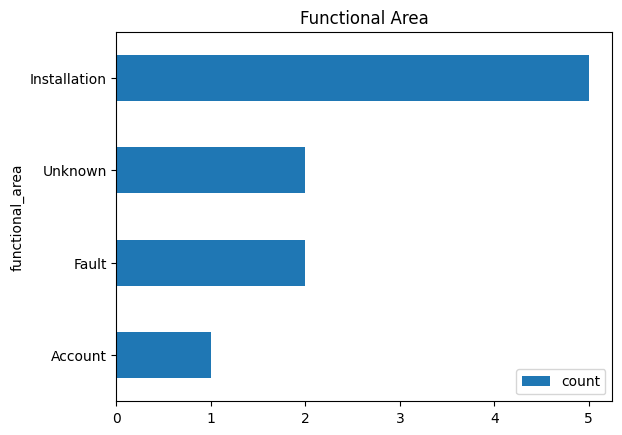

In [12]:
pd.DataFrame(df['functional_area'].value_counts()).sort_values('count', ascending=True).plot(kind="barh")
plt.title('Functional Area')
plt.show()

#### product

In [13]:
product_category = ["Fixed Line Voice", "Broadband", "TV", "Mobile", "Multiple Products", "Unknown"]

In [14]:
product_prompt = """        
        Classify the text within the square brackets into ONE of the following products listed in inverted commas below:-
         1. "Fixed Line Voice" if the text contains words like fixed line voice, unable to make or receive calls, no voice service, digital voice, dv, dv phone, dv handset, dv service, or, no dial tone. 
         2. "Broadband" if the text contains words like broadband, broadband fault, broadband connection, hybrid connect, slow speed, speedtest, wifi, wifi discs, discs, wifi disc or disc. 
         3. "TV" if the text contains words like TV, set top box, xbox, sky, channels, and tv.
         4. "Mobile" if the text contains the words like EE Mobile, Mobile, or, Mobile handset.
         5. "Multiple Products" if the text clearly relates to more than ONE product.
         6. "Unknown" if not sure about which product listed 1. to 5. it relates to.
         
        
        Return ONE product with no additional characters. Do not create any new products.
"""

In [15]:
def find_product(model, parameters, product_prompt, text):
    input_text = f"{product_prompt}\n[{text}]\n"
    response = model.predict(input_text, **parameters)
    if response.text.strip() in product_category:
        return response.text.strip() 
    else:
        return 'Unknown'

In [16]:
def apply_find_product_parallel(comments, product_prompt, model, parameters):
    num_cpus = multiprocessing.cpu_count()
    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = [executor.submit(find_product, model, parameters, product_prompt, comment) for comment in comments]
        results = []
        for future in as_completed(futures):
            results.append(future.result())
        return results

In [17]:
%%time
products = apply_find_product_parallel(comments, product_prompt, model, parameters)

CPU times: user 24.6 ms, sys: 12.2 ms, total: 36.8 ms
Wall time: 1.21 s


In [18]:
df['product'] = products

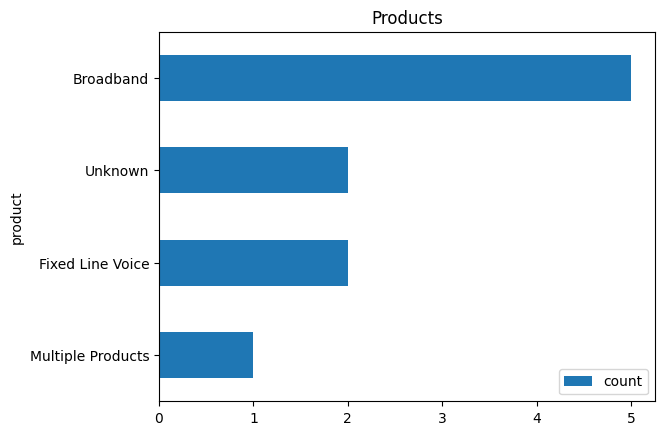

In [19]:
pd.DataFrame(df['product'].value_counts()).sort_values('count', ascending=True).plot(kind="barh")
plt.title('Products')
plt.show()

In [20]:
file_path = '../output/classification.csv'
df.to_csv(file_path, index=False) 

In [21]:
df.head(10)

,COMMENTS_LONG,tokens,clean,Without PII,Topic,Category,ASSET_NUM,Words,Second Topic,Second Category,Vlookup,functional_area,product
1858,date: * \nreason for call: xfered from tech - calling back as desperate for broadband to go line \naction taken: fttp order completed 19.1.24 ( from another cp) : vol013-828046934669 / broadbandeu54912428 * orange light on hub since 19.1.24 but ont has all green lights * hview cannot access hub * new in ws does not recognise * checked order in ws and this is still open (hud does not show any order info for broadbandeu54912428 or ) * checked interactions and can see notes that customers broadband order us stuck and has an open exception which has been chased and nrd / activation is expected for * cust works from home and cannot * wife works from home and cannot - already used all her mobile data * son studying for a levels and cannot as ee dongle pre sent is too slow * apologised for poor experience . i have added gb mobile data to wife emmas ee mobile (info data pass gb move house data boost [ yhaddac20 ] was purchased successfully for msisdn ) (cust and son have unlimited) * no ee hot spots * complaint logged and callback booked for * \nnext action due : call ish .. mobile .. has broadband connected ? can we see the broadband in or ws broadbandeu54912428 .. customer knows auto comp will be payable from 19.1.24 *,"['date', 'reason', 'for', 'call', 'xfered', 'from', 'tech', 'calling', 'back', 'as', 'desperate', 'for', 'broadband', 'to', 'go', 'line', 'action', 'taken', 'fttp', 'order', 'completed', 'from', 'another', 'cp', 'orange', 'light', 'on', 'hub', 'since', 'but', 'ont', 'has', 'all', 'green', 'lights', 'hview', 'can', 'not', 'access', 'hub', 'new', 'in', 'ws', 'does', 'not', 'recognise', 'checked', 'order', 'in', 'ws', 'and', 'this', 'is', 'still', 'open', 'hud', 'does', 'not', 'show', 'any', 'order', 'info', 'for', 'or', 'checked', 'interactions', 'and', 'can', 'see', 'notes', 'that', 'customers', 'broadband', 'order', 'us', 'stuck', 'and', 'has', 'an', 'open', 'exception', 'which', 'has', 'been', 'chased', 'and', 'nrd', 'activation', 'is', 'expected', 'for', 'cust', 'works', 'from', 'home', 'and', 'can', 'not', 'wife', 'works', 'from', 'home', 'and', 'can', 'not', 'already', 'used', 'all', 'her', 'mobile', 'data', 'son', 'studying', 'for', 'levels', 'and', 'can', 'not', 'as', 'ee', 'dongle', 'pre', 'sent', 'is', 'too', 'slow', 'apologised', 'for', 'poor', 'experience', 'have', 'added', 'gb', 'mobile', 'data', 'to', 'wife', 'emmas', 'ee', 'mobile', 'info', 'data', 'pass', 'gb', 'move', 'house', 'data', 'boost', 'was', 'purchased', 'successfully', 'for', 'msisdn', 'cust', 'and', 'son', 'have', 'unlimited', 'no', 'ee', 'hot', 'spots', 'complaint', 'logged', 'and', 'callback', 'booked', 'for', 'next', 'action', 'due', 'call', 'ish', 'mobile', 'has', 'broadband', 'connected', 'can', 'we', 'see', 'the', 'broadband', 'in', 'or', 'ws', 'customer', 'knows', 'auto', 'comp', 'will', 'be', 'payable', 'from']",date reason for call xfered from tech calling back as desperate for broadband to go line action taken fttp order completed from another cp orange light on hub since but ont has all green lights hview can not access hub new in ws does not recognise checked order in ws and this is still open hud does not show any order info for or checked interactions and can see notes that customers broadband order us stuck and has an open exception which has been chased and nrd activation is expected for cust works from home and can not wife works from home and can not already used all her mobile data son studying for levels and can not as ee dongle pre sent is too slow apologised for poor experience have added gb mobile data to wife emmas ee mobile info data pass gb move house data boost was purchased successfully for msisdn cust and son have unlimited no ee hot spots complaint logged and callback booked for next action due call ish mobile has broadband connected can we see the broadband in or ws customer k

#### Create a 2x2 table

In [22]:
pd.crosstab(df['functional_area'],df['product'], margins=True)

product,Broadband,Fixed Line Voice,Multiple Products,Unknown,All
functional_area,,,,,
Account,1,0,0,0,1
Fault,2,0,0,0,2
Installation,1,2,1,1,5
Unknown,1,0,0,1,2
All,5,2,1,2,10


In [23]:
round(pd.crosstab(df['functional_area'],df['product'], normalize=True, margins=True),3)*100

product,Broadband,Fixed Line Voice,Multiple Products,Unknown,All
functional_area,,,,,
Account,10.0,0.0,0.0,0.0,10.0
Fault,20.0,0.0,0.0,0.0,20.0
Installation,10.0,20.0,10.0,10.0,50.0
Unknown,10.0,0.0,0.0,10.0,20.0
All,50.0,20.0,10.0,20.0,100.0
